In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

INFO: Using pytorch backend


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from geomstats.learning.pca import TangentPCA
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

import cells.cells.features.basic as basic


CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.square_root_velocity_metric

In [4]:
n_cells = 80
n_sampling_points = 50

In [5]:
labels_a_name = "lines"
labels_b_name = "treatments"

In [6]:
import cells.cells.datasets.experimental as experimental

cells, cell_shapes, labels_a, labels_b = experimental.load_treated_osteosarcoma_cells(
    n_cells=n_cells, n_sampling_points=n_sampling_points
)

Selecting only a random subset of 80 / 650 cells.
Interpolating: All cells get 50 samplings points
Removing potential duplicate points.
Cells: quotienting translation.
Cell shapes: quotienting scaling (length).
Cell shapes: quotienting rotation.


In [7]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}
print(labels_a_dict)
print(labels_b_dict)

{'dlm8': 0, 'dunn': 1}
{'control': 0, 'cytd': 1, 'jasp': 2}


# Sample Means

In [8]:
mean = gs.mean(cells, axis=0)

frechet_mean = FrechetMean(metric=SRV_METRIC, point_type="matrix", method="default")
frechet_mean.fit(cell_shapes)
mean_shape = frechet_mean.estimate_

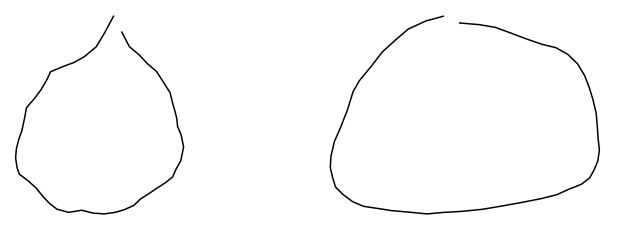

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(mean[:, 0], mean[:, 1], "black")
axs[1].plot(mean_shape[:, 0], mean_shape[:, 1], "black")
axs[0].set_aspect("equal")
axs[0].axis("off")
axs[1].set_aspect("equal")
axs[1].axis("off");

# Distances to the mean

In [12]:
dists = [
    gs.linalg.norm(mean - cell).numpy() / n_sampling_points for cell in cells
]

dists_shape = [
    SRV_METRIC.dist(mean_shape, cell).numpy() / n_sampling_points for cell in cells
]

In [13]:
summary = pd.DataFrame(
    data={
        "dists": dists,
        "dists_shape": dists_shape,
        labels_a_name: labels_a,
        labels_b_name: labels_b,
    }
)

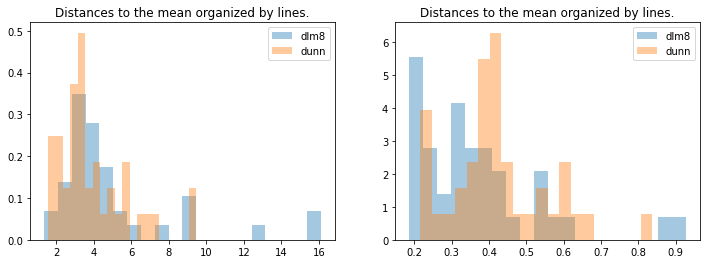

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, dist_name in enumerate(["dists", "dists_shape"]):
    for i_lab, label_a in enumerate(np.unique(labels_a)):
        ds = summary[dist_name][summary[labels_a_name] == label_a]
        axs[i].hist(
            ds, bins=20, alpha=0.4, density=True, label=label_a, color=f"C{i_lab}"
        )
    axs[i].legend()
    axs[i].set_title(f"Distances to the mean organized by {labels_a_name}.")

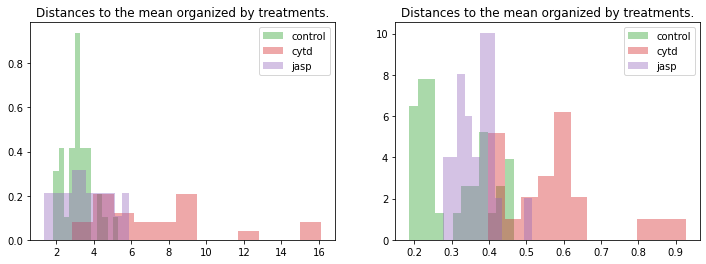

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, dist_name in enumerate(["dists", "dists_shape"]):
    for i_lab, label_b in enumerate(np.unique(labels_b)):
        ds = summary[dist_name][summary[labels_b_name] == label_b]
        axs[i].hist(
            ds, bins=12, alpha=0.4, density=True, label=label_b, color=f"C{2+i_lab}"
        )
    axs[i].legend()
    axs[i].set_title(f"Distances to the mean organized by {labels_b_name}.")

# Clustering on distances with KMeans

In [16]:
def reorder_confusion_matrix(cmat):
    def _make_cost_m(cm):
        s = np.max(cm)
        return -cm + s

    indexes = linear_assignment(_make_cost_m(cmat))
    js = sorted(indexes, key=lambda x: x[0])[1]
    cm2 = cmat[:, js]
    return cm2

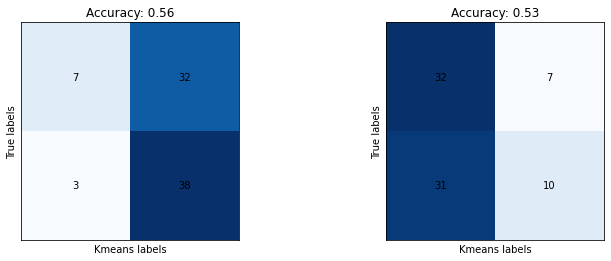

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, dist_name in enumerate(["dists", "dists_shape"]):
    dists_arr = gs.expand_dims(gs.array(summary[dist_name]), axis=1)
    kmeans = KMeans(n_clusters=len(labels_a_dict), random_state=0).fit(dists_arr)
    true_labels = [labels_a_dict[lab] for lab in labels_a]
    cm = confusion_matrix(true_labels, kmeans.labels_)
    cm = reorder_confusion_matrix(cm)

    axs[i].imshow(cm, interpolation="none", cmap="Blues")
    for (ii, jj), z in np.ndenumerate(cm):
        axs[i].text(jj, ii, z, ha="center", va="center")

    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])
    axs[i].set_xlabel("Kmeans labels")
    axs[i].set_ylabel("True labels")

    acc = np.trace(cm) / np.sum(cm)
    axs[i].set_title(f"Accuracy: {acc:.2f}")

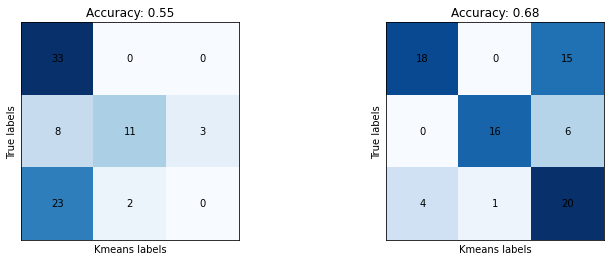

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, dist_name in enumerate(["dists", "dists_shape"]):
    dists_arr = gs.expand_dims(gs.array(summary[dist_name]), axis=1)
    kmeans = KMeans(n_clusters=len(labels_b_dict), random_state=0).fit(dists_arr)
    true_labels = [labels_b_dict[lab] for lab in labels_b]
    cm = confusion_matrix(true_labels, kmeans.labels_)
    cm = reorder_confusion_matrix(cm)

    axs[i].imshow(cm, interpolation="none", cmap="Blues")
    for (ii, jj), z in np.ndenumerate(cm):
        axs[i].text(jj, ii, z, ha="center", va="center")

    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])
    axs[i].set_xlabel("Kmeans labels")
    axs[i].set_ylabel("True labels")

    acc = np.trace(cm) / np.sum(cm)
    axs[i].set_title(f"Accuracy: {acc:.2f}")

# Dimension Reduction with PCA and tPCA

In [19]:
cells_flat = gs.reshape(cells, (len(cells), -1))

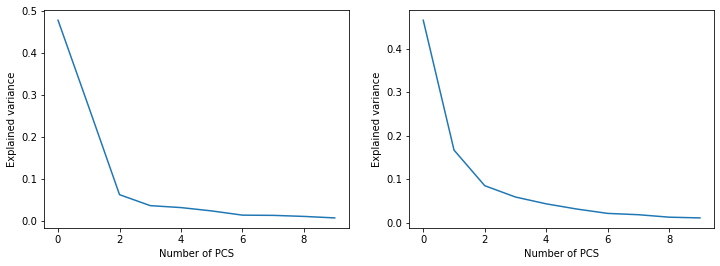

In [20]:
n_components = 10
pca = PCA(n_components=n_components).fit(cells_flat)

pca_shape = TangentPCA(n_components=n_components, metric=SRV_METRIC).fit(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(pca.explained_variance_ratio_)
axs[1].plot(pca_shape.explained_variance_ratio_)

for i in range(2):
    axs[i].set_xlabel("Number of PCS")
    axs[i].set_ylabel("Explained variance")

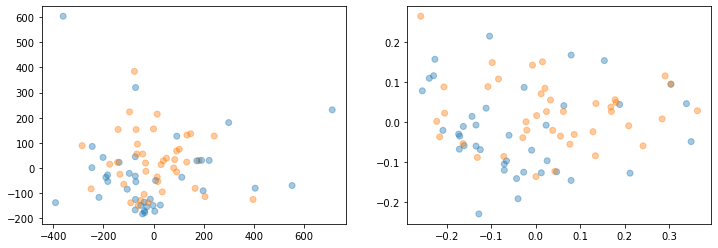

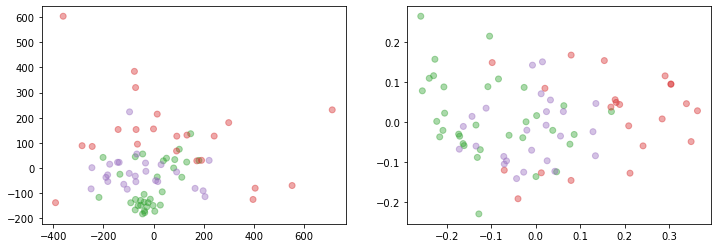

In [21]:
cell_transformed = []
cell_transformed.append(pca.fit_transform(cells_flat))
cell_transformed.append(pca_shape.fit_transform(cell_shapes))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, cell_tr in enumerate(cell_transformed):
    axs[i].scatter(
        cell_tr[:, 0],
        cell_tr[:, 1],
        c=[f"C{labels_a_dict[lab]}" for lab in labels_a],
        alpha=0.4,
    )

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, cell_tr in enumerate(cell_transformed):
    axs[i].scatter(
        cell_tr[:, 0],
        cell_tr[:, 1],
        c=[f"C{labels_b_dict[lab]+2}" for lab in labels_b],
        alpha=0.4,
    );

In [22]:
times = np.arange(-0.5, 0.5, 0.1)


def plot_pc(geod, i_pc):
    fig = plt.figure(figsize=(4, 1.5))
    for i, curve in enumerate(geod):
        fig.add_subplot(1, len(times), i + 1)
        plt.plot(curve[:, 0], curve[:, 1], c=f"C{i_pc+6}")
        plt.axis("equal")

        plt.axis("off")
        plt.tight_layout()
    fig.suptitle(f"PC{i_pc}")

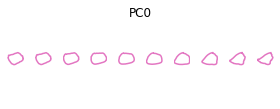

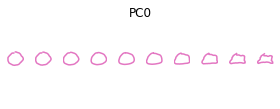

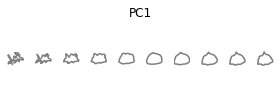

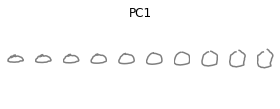

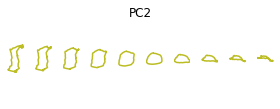

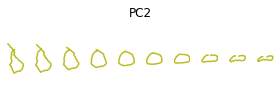

In [23]:
n_pcs = 3

for i_pc in range(n_pcs):
    pc = mean_shape + np.einsum(
        "n,ij->nij", times, pca.components_[i_pc].reshape((n_sampling_points, 2))
    )
    plot_pc(pc, i_pc=i_pc)

    gpc = SRV_METRIC.geodesic(
        initial_curve=mean_shape,
        initial_tangent_vec=pca_shape.components_[i_pc].reshape((n_sampling_points, 2)),
    )(times)

    plot_pc(gpc, i_pc=i_pc)

# Dimension Reduction via MDS

In [24]:
def linear_dist(cell1, cell2):
    return np.linalg.norm(cell1 - cell2) / n_sampling_points


def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

In [30]:
@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i+1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

In [31]:
pairwise_dists = parallel_dist(cells.numpy(), dist_fun=linear_dist)

INFO: finding looplift candidates


In [32]:
# This takes 7min
pairwise_dists_shape = parallel_dist(cells, dist_fun=srv_dist)

INFO: finding looplift candidates


In [33]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists).embedding_

mds_shape = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos_shape = mds_shape.fit(pairwise_dists_shape).embedding_

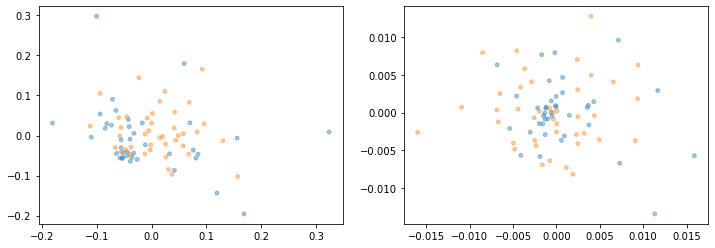

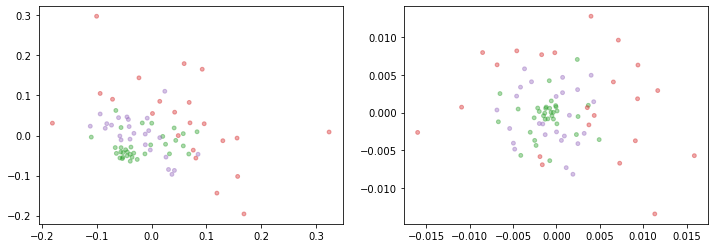

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, position in enumerate([pos, pos_shape]):
    axs[i].scatter(
        position[:, 0],
        position[:, 1],
        c=[f"C{labels_a_dict[lab]}" for lab in labels_a],
        alpha=0.4,
        s=15,
    )

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, position in enumerate([pos, pos_shape]):
    axs[i].scatter(
        position[:, 0],
        position[:, 1],
        c=[f"C{labels_b_dict[lab]+2}" for lab in labels_b],
        alpha=0.4,
        s=15,
    )

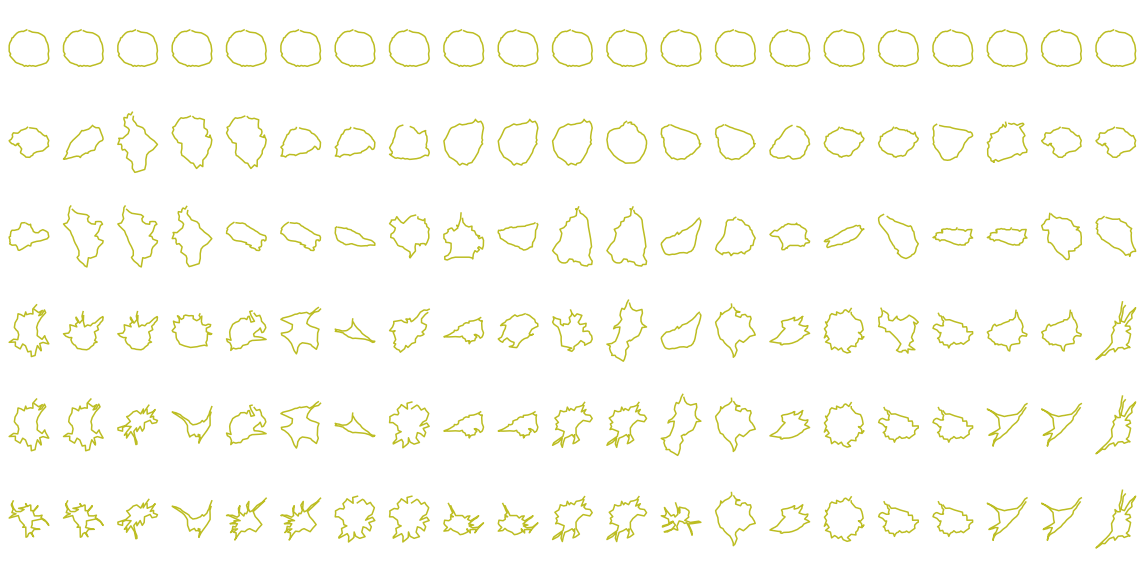

In [35]:
fig = plt.figure(figsize=(16, 8))
thetas = np.arange(0, 2 * np.pi, 0.3)
radii = np.arange(0, 0.015, 0.0025)

count = 0
for radius in radii:
    for theta in thetas:
        fig.add_subplot(len(radii), len(thetas), count + 1)

        pos_theta = np.array([radius * np.cos(theta), radius * np.sin(theta)])
        dists_theta = np.linalg.norm(pos_theta - pos_shape, axis=1)
        assert len(dists_theta) == n_cells
        idx = np.argmin(dists_theta)

        plt.plot(cells[idx][:, 0], cells[idx][:, 1], c=f"C{i_pc+6}")
        plt.axis("equal")
        plt.axis("off")
        plt.tight_layout()
        count += 1
    plt.ylabel(f"Radius: {radius}")

The distance in MDS space is the distance to the mean shape.

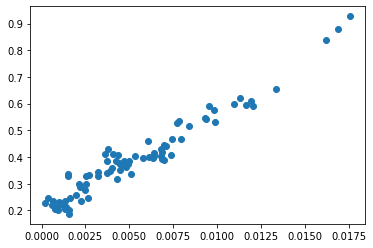

In [36]:
plt.scatter(np.linalg.norm(pos_shape, axis=1), dists_shape);

In [277]:
areas = []
lengths = []
features = []
for cell in cells:
    area = basic.area(cell)
    length = basic.perimeter(cell)
    areas.append(area)
    lengths.append(length)
    features.append(area / length)

NameError: name 'np' is not defined

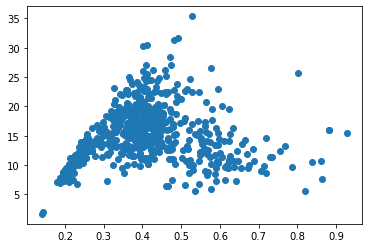

In [219]:
plt.scatter(dists_shape, features);

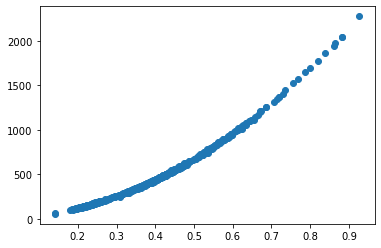

In [221]:
plt.scatter(dists_shape, lengths);

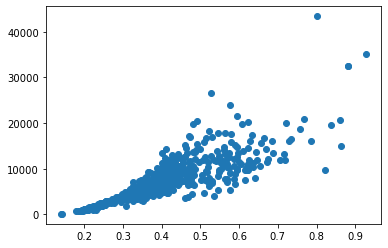

In [222]:
plt.scatter(dists_shape, areas);

In [224]:
areas = []
lengths = []
features = []
for cell in cell_shapes:
    area = poly_area(cell)
    length = poly_perimeter(cell)
    areas.append(area)
    lengths.append(length)
    features.append(area / length)

In [225]:
lengths

[0.994315,
 1.0232801,
 0.91473687,
 0.9370604,
 0.9223077,
 0.9277206,
 0.9153463,
 0.95819736,
 0.9555086,
 0.9445417,
 0.93045807,
 1.0017722,
 0.9062829,
 0.9117072,
 0.93357605,
 0.9426136,
 1.0644722,
 1.0168893,
 1.1446371,
 0.9537754,
 0.9125261,
 0.9042872,
 0.928927,
 0.95810884,
 0.9454886,
 0.91985273,
 0.93125486,
 0.9338249,
 0.9267459,
 0.9665813,
 0.89944905,
 0.96358174,
 1.0113053,
 1.0121082,
 0.9626829,
 0.92510563,
 0.95298976,
 0.9047178,
 0.99165285,
 0.90634674,
 0.9015827,
 0.90845823,
 1.0616283,
 0.93128186,
 0.9084941,
 0.95130175,
 0.9636776,
 0.9111239,
 0.8994461,
 0.91722524,
 0.952082,
 0.96693367,
 0.92692876,
 0.88763183,
 0.9047012,
 1.2942849,
 1.0149418,
 1.0499388,
 1.0561858,
 0.9868265,
 1.2222471,
 0.9571424,
 0.96049124,
 1.1441032,
 1.0086335,
 1.0120084,
 1.2720219,
 1.1321591,
 0.9659529,
 0.99833226,
 1.1822231,
 1.0216811,
 1.0473237,
 1.0959718,
 1.0381554,
 1.0545844,
 1.0364903,
 1.130721,
 1.0255651,
 0.92380357,
 0.92663693,
 0.97846

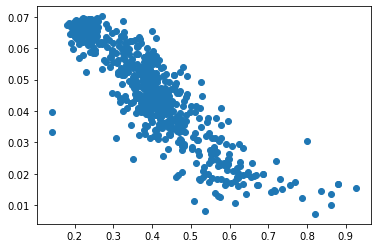

In [226]:
plt.scatter(dists_shape, features);